In [26]:
import pandas as pd
import os
from pathlib import Path, PureWindowsPath
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

# Load files in

In [2]:
filename_1 = 'FEMA_claims.csv.gz'
filename_2 = 'ASEC_income.csv.gz'
filename_3 = 'ZHVI.csv.gz'
url = Path(PureWindowsPath('C:\\Users\\woodn\\github\\datasets'))
filepath_1 = url / filename_1
filepath_2 = url / filename_2
filepath_3 = url / filename_3

In [3]:
df_fema = pd.read_csv(filepath_1,
                      on_bad_lines = 'warn',
                      low_memory = False
                     )
df_asec = pd.read_csv(filepath_2,
                      on_bad_lines = 'warn',
                      low_memory = False
                     )
df_zhvi = pd.read_csv(filepath_3,
                      on_bad_lines = 'warn',
                      low_memory = False
                     )

# Aggregate FEMA data down to year for y-o-y analysis

In [4]:
df_fema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20644383 entries, 0 to 20644382
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   county          object 
 2   state           object 
 3   city            object 
 4   zip             object 
 5   damage          float64
 6   reimbursements  float64
dtypes: float64(2), object(5)
memory usage: 1.1+ GB


In [6]:
df_fema.sample(3)

,date,county,state,city,zip,damage,reimbursements
17457816,2021-08-29,Tangipahoa,LA,HAMMOND,70401,0.0,0.0
13964040,2017-09-20,San German,PR,SAN GERMAN,00683,0.0,0.0
6206370,2008-09-02,Tangipahoa,LA,HAMMOND,70403,0.0,0.0


In [8]:
try:
    df_fema['year'] = pd.to_datetime(arg=df_fema.loc[:,'date']
                                     ,errors='raise'
                                     ,format="%Y-%m-%d"
                                    ).dt.year
except:
    print('that ain\'t it man')

In [9]:
df_fema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20644383 entries, 0 to 20644382
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   county          object 
 2   state           object 
 3   city            object 
 4   zip             object 
 5   damage          float64
 6   reimbursements  float64
 7   year            int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 1.2+ GB


In [21]:
df2_fema = df_fema.groupby(by=['state','county','year'], as_index=False)\
                    .agg(tot_reim = ('reimbursements','sum')
                         ,cnt_req = ('reimbursements','count')
                        ).dropna()

In [22]:
df2_fema.sample(3)

,state,county,year,tot_reim,cnt_req
4904,NC,Brunswick,2011,77325.20,221
5271,ND,Ramsey,2009,187667.32,333
4097,MO,Hickory,2006,143915.50,69


In [23]:
df2_fema.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9198 entries, 0 to 9221
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   state     9198 non-null   object 
 1   county    9198 non-null   object 
 2   year      9198 non-null   int64  
 3   tot_reim  9198 non-null   float64
 4   cnt_req   9198 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 431.2+ KB


# Fit a model for each year to cluster into: low,med,high

In [ ]:
# df2_fema.loc[:,'year'].unique().tolist()
# for y in range(2005,2023):
#     X = df2_fema.loc[df2_fema.loc[:,'year']==y,'tot_reim','cnt_req']
#     df2_fema.loc[df2_fema.loc[:,'year']==y,'cluster'] = KMeans(n_clusters=3).fit_predict(X)


In [27]:
y = 2020
df_temp = df2_fema.loc[df2_fema.loc[:,'year']==y,:]
filt = df2_fema.loc[:,'year']==y
X = df_temp.loc[filt,['tot_reim','cnt_req']]
mdl = KMeans(n_clusters=3).fit(X)
df_temp.loc[:,'cluster'] = mdl.predict(X)

C:\ProgramData\Anaconda3\envs\ML_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\woodn\AppData\Local\Temp\ipykernel_16200\1662957337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.loc[:,'cluster'] = KMeans(n_clusters=3).fit_predict(X)


<Axes: xlabel='tot_reim', ylabel='cnt_req'>

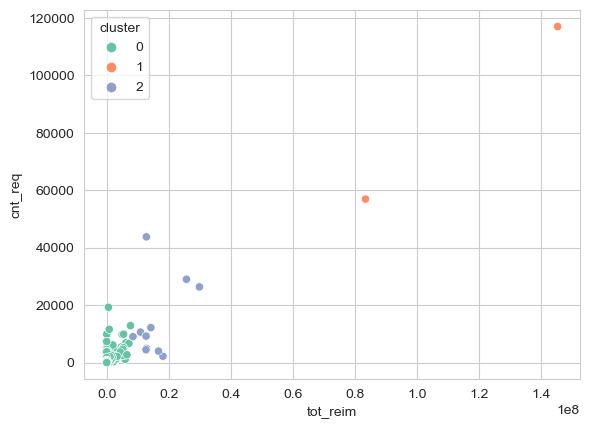

In [34]:
sns.set_style('whitegrid')
sns.scatterplot(data=df_temp,
                x='tot_reim',
                y='cnt_req',
                hue='cluster',
                palette='Set2'
               )